In [396]:
# data processing
import pandas as pd
import numpy as np

# modelling
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Conv2D, MaxPooling2D, UpSampling2D, Dense, Conv2DTranspose, Input, Flatten, Layer, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import binary_accuracy, Mean
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import mae, binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity

# visualization
import matplotlib.pyplot as plt
import seaborn as sn

# misc
import random as rn

Dataset split: 60000 train rows 60000 test rows


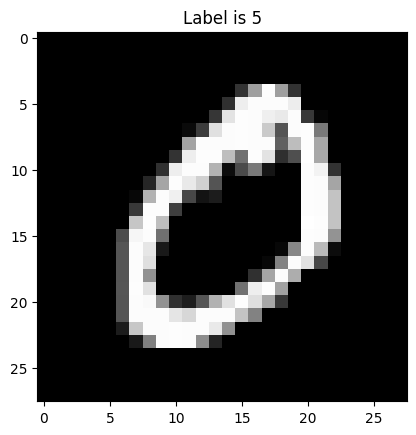

In [397]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"Dataset split: {len(x_train.data)} train rows",
          f"{len(y_train.data)} test rows")

point = np.array(x_train[0], dtype='float')
point = point.reshape((28, 28))
plt.title('Label is {label}'.format(label=y_train[0]))
plt.imshow(x_train[1], cmap='gray')
plt.show()

In [398]:
# normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print("x_train shape:", x_train.shape)
print("x_train shape:", x_test.shape)

x_train shape: (60000, 28, 28)
x_train shape: (10000, 28, 28)


In [399]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [400]:
# create an anomaly hold out group and then only train with the remaining digits
anom_mask = (y_train == 9)
anomaly_test = x_train[anom_mask]
X_train = x_train[~anom_mask]
y_train = y_train[~anom_mask]

In [401]:
# make a test set the same size as the anomaly set
X_train, X_test, Y_train, Y_test = train_test_split(X_train, y_train, test_size=anomaly_test.shape[0], random_state=42)
print('Training Images', X_train.shape, 'Testing Images', X_test.shape, 'Anomaly Images', anomaly_test.shape)

Training Images (48102, 28, 28, 1) Testing Images (5949, 28, 28, 1) Anomaly Images (5949, 28, 28, 1)


In [403]:
# model settings
batch_size = 256
original_shape = X_train.shape[1:]
original_dim = np.prod(original_shape)
latent_dim = 4
intermediate_dim = 128
final_dim = 64
epochs = 50
epsilon_std = 1.0

In [404]:
# sampling
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [405]:
# build model
encoder_inputs = Input(shape=original_shape)
x = Flatten()(encoder_inputs)
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(final_dim, activation = 'relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [406]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [407]:
# we instantiate these layers separately so as to reuse them later
decoder_f = Dense(final_dim, activation='relu')
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

In [408]:
f_decoded = decoder_f(z)
h_decoded = decoder_h(f_decoded)
x_decoded_mean = decoder_mean(h_decoded)
x_decoded_img = Reshape(original_shape)(x_decoded_mean)

In [409]:
# instantiate VAE model
vae = Model(encoder_inputs, x_decoded_img)

In [410]:
# Compute VAE loss
reconstruction_loss = original_dim * binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [411]:
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_42 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 flatten_15 (Flatten)        (None, 784)                  0         ['input_42[0][0]']            
                                                                                                  
 dense_175 (Dense)           (None, 128)                  100480    ['flatten_15[0][0]']          
                                                                                                  
 dense_176 (Dense)           (None, 64)                   8256      ['dense_175[0][0]']           
                                                                                            

                                                                                                  
 tf.math.subtract_32 (TFOpL  (None, 4)                    0         ['tf.math.subtract_31[0][0]', 
 ambda)                                                              'tf.math.exp_19[0][0]']      
                                                                                                  
 tf.math.reduce_mean_22 (TF  (None,)                      0         ['tf.keras.backend.binary_cros
 OpLambda)                                                          sentropy_17[0][0]']           
                                                                                                  
 tf.math.reduce_sum_17 (TFO  (None,)                      0         ['tf.math.subtract_32[0][0]'] 
 pLambda)                                                                                         
                                                                                                  
 tf.math.m

In [412]:
history = vae.fit(x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(anomaly_test, None))

Epoch 1/50
235/235 [==============================] - 2s 4ms/step - loss: 202.6241 - val_loss: 146.7849
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 161.3712 - val_loss: 136.1978
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 153.4718 - val_loss: 131.5820
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 148.3733 - val_loss: 128.7222
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 144.7824 - val_loss: 128.7905
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 142.0766 - val_loss: 127.2261
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 140.1521 - val_loss: 126.5086
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 138.6452 - val_loss: 125.3575
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 137.4344 - val_loss: 123.7835
Epoch 10/50
235/235 [==============================] - 1s 4ms/st

In [413]:
encoder = Model(encoder_inputs, z_mean)
# display a 2D plot of the digit classes in the latent space
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)

24/24 [==============================] - 0s 915us/step


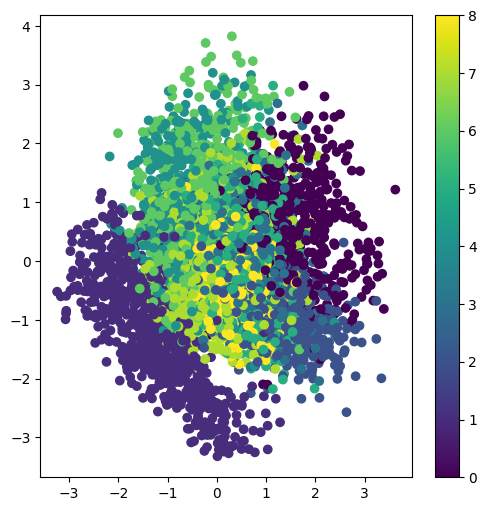

In [414]:
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
plt.colorbar()
plt.show()

24/24 [==============================] - 0s 903us/step


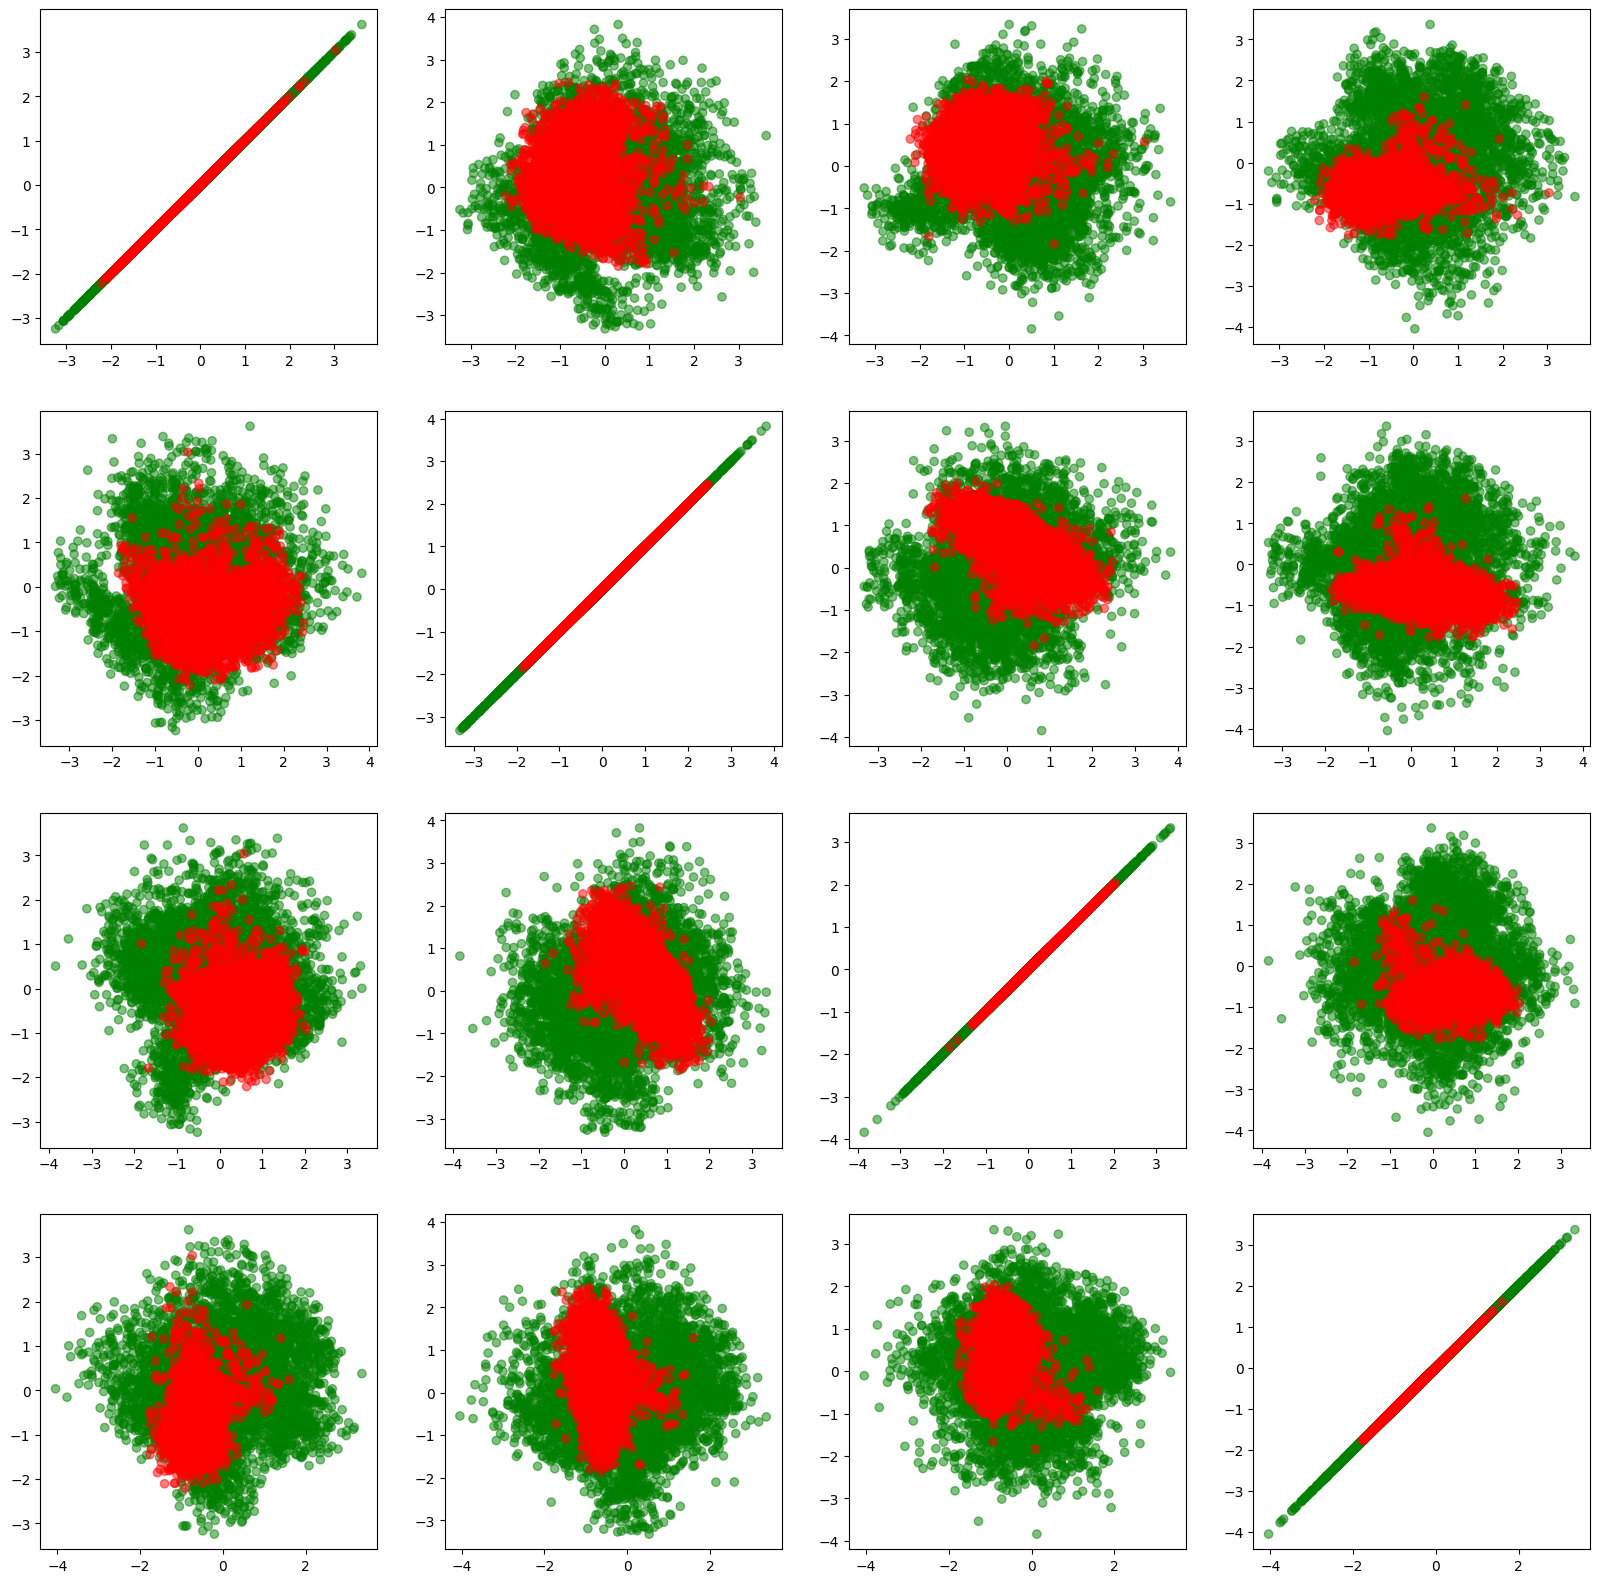

In [415]:
anomaly_encoded = encoder.predict(anomaly_test, batch_size=batch_size)
fig, m_axs = plt.subplots(latent_dim,latent_dim, figsize=(latent_dim*5, latent_dim*5))
if latent_dim == 1:
    m_axs = [[m_axs]]
for i, n_axs in enumerate(m_axs, 0):
    for j, c_ax in enumerate(n_axs, 0):
        c_ax.scatter(np.concatenate([X_test_encoded[:, i], anomaly_encoded[:,i]],0), 
                           np.concatenate([X_test_encoded[:, j], anomaly_encoded[:,j]],0),
            c=(['g']*X_test_encoded.shape[0])+['r']*anomaly_encoded.shape[0], alpha = 0.5)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11898 samples in 0.006s...
[t-SNE] Computed neighbors for 11898 samples in 0.302s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11898
[t-SNE] Computed conditional probabilities for sample 2000 / 11898
[t-SNE] Computed conditional probabilities for sample 3000 / 11898
[t-SNE] Computed conditional probabilities for sample 4000 / 11898
[t-SNE] Computed conditional probabilities for sample 5000 / 11898
[t-SNE] Computed conditional probabilities for sample 6000 / 11898
[t-SNE] Computed conditional probabilities for sample 7000 / 11898
[t-SNE] Computed conditional probabilities for sample 8000 / 11898
[t-SNE] Computed conditional probabilities for sample 9000 / 11898
[t-SNE] Computed conditional probabilities for sample 10000 / 11898
[t-SNE] Computed conditional probabilities for sample 11000 / 11898
[t-SNE] Computed conditional probabilities for sample 11898 / 11898
[t-SNE] Mean sigma: 0.181044
[t-SNE] KL divergence

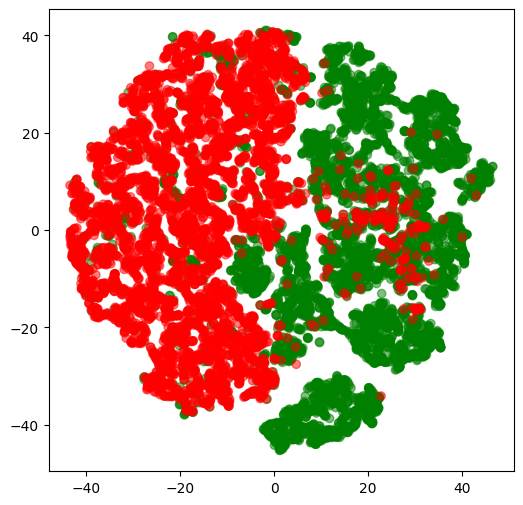

In [416]:
latent_space_tsne = TSNE(2, verbose = True, n_iter = 500)
xa_tsne = latent_space_tsne.fit_transform(np.concatenate([X_test_encoded[:, :], anomaly_encoded[:,:]],0))

plt.figure(figsize=(6, 6))
plt.scatter(xa_tsne[:,0], xa_tsne[:,1],
            c=(['g']*X_test_encoded.shape[0])+['r']*anomaly_encoded.shape[0], alpha = 0.5)
plt.show()

24/24 [==============================] - 0s 2ms/step


Text(0.5, 0, 'Reconstruction Error')

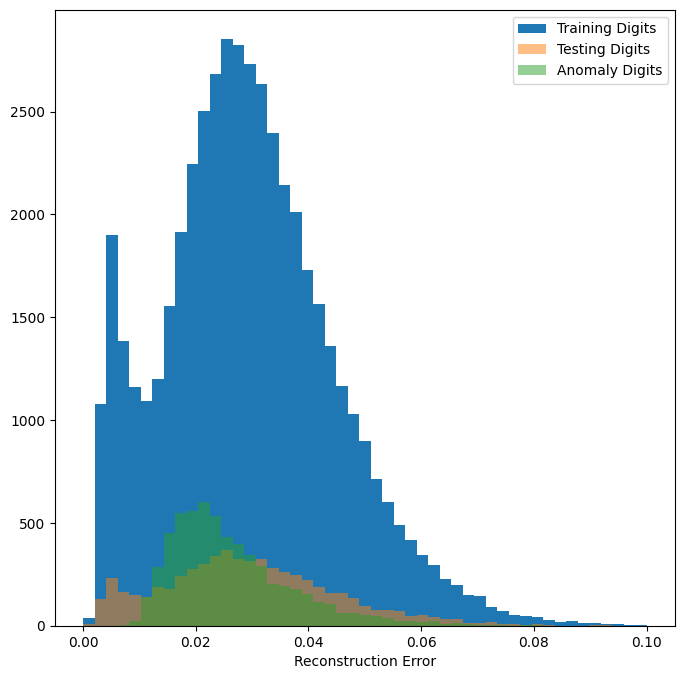

In [418]:
model_mse = lambda x: np.mean(np.square(x-vae.predict(x, batch_size = batch_size)), (1,2,3))
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(X_train), bins = np.linspace(0, .1, 50), label = 'Training Digits', alpha = 1.0)
ax1.hist(model_mse(X_test), bins = np.linspace(0, .1, 50), label = 'Testing Digits', alpha = 0.5)
ax1.hist(model_mse(anomaly_test), bins = np.linspace(0, .1, 50), label = 'Anomaly Digits', alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error')

1504/1504 [==============================] - 1s 676us/step
Test data score -6.113963720526318
Anomaly score -5.8341393643745825


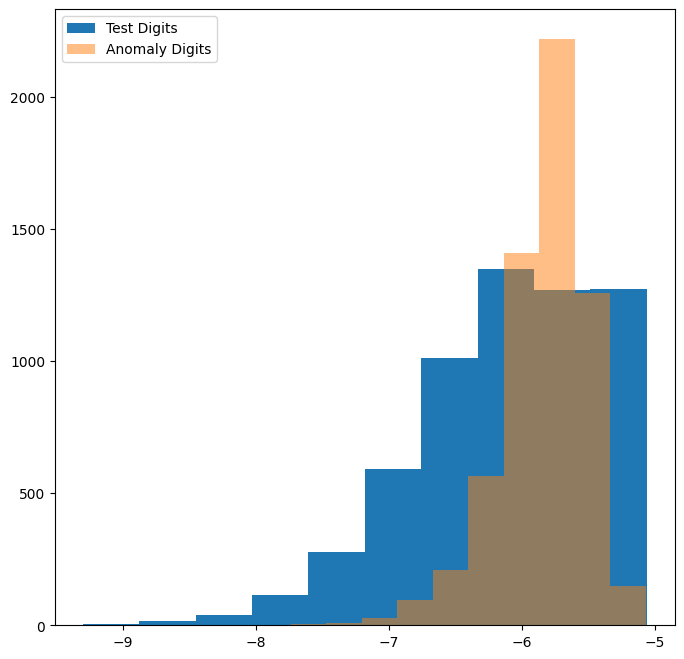

In [419]:
kd = KernelDensity()
kd.fit(encoder.predict(X_train))
test_score = [kd.score(x.reshape(1, -1)) for x in X_test_encoded]
anom_score = [kd.score(x.reshape(1, -1)) for x in anomaly_encoded]
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(test_score, label = 'Test Digits', alpha = 1.0)
ax1.hist(anom_score, label = 'Anomaly Digits', alpha = 0.5)
ax1.legend()
print('Test data score', np.mean(test_score))
print('Anomaly score', np.mean(anom_score))

24/24 [==============================] - 0s 2ms/step


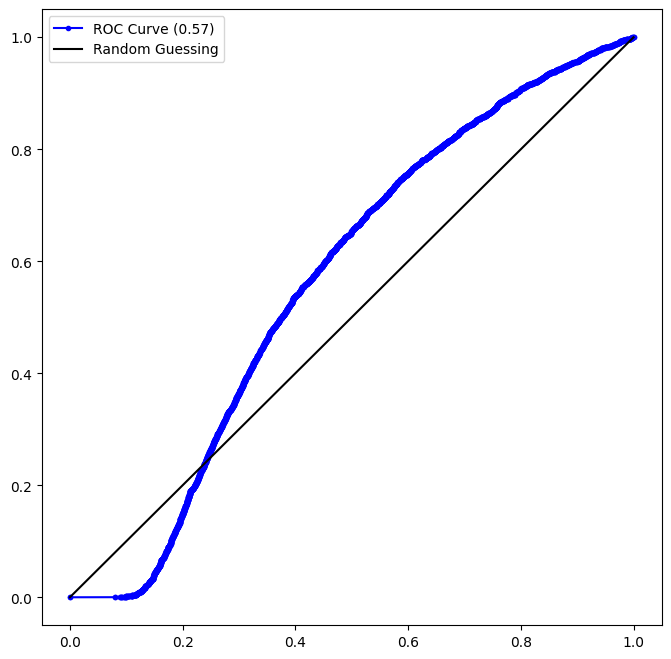

In [420]:
mse_score = np.concatenate([model_mse(X_test), model_mse(anomaly_test)],0)
true_label = [0]*X_test.shape[0]+[1]*anomaly_test.shape[0]
if roc_auc_score(true_label, mse_score)<0.5:
    mse_score *= -1
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend()

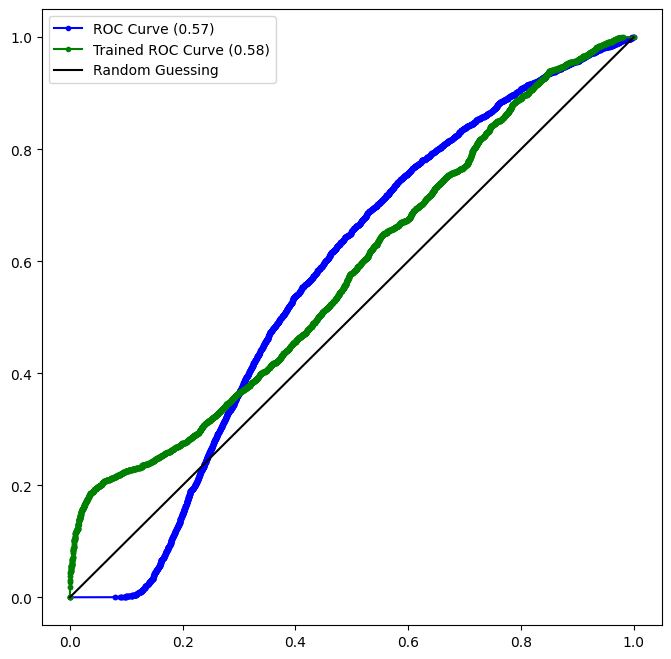

In [421]:
anom_exam = np.mean(xa_tsne[-3:,:],0)
mse_score_train = np.sqrt(np.square(xa_tsne[:,0]-anom_exam[0])+np.square(xa_tsne[:,1]-anom_exam[1]))
if roc_auc_score(true_label, mse_score_train)<0.5:
    mse_score_train *= -1

fpr_new, tpr_new, thresholds = roc_curve(true_label, mse_score_train)
auc_score_new = roc_auc_score(true_label, mse_score_train)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr_new, tpr_new, 'g.-', label = 'Trained ROC Curve (%2.2f)' %  auc_score_new)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend()

In [422]:
decoder_input = Input(shape=(latent_dim,))
_f_decoded = decoder_f(decoder_input)
_h_decoded = decoder_h(_f_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
_x_decoded_img = Reshape(original_shape)(_x_decoded_mean)
generator = Model(decoder_input, _x_decoded_img)

1/1 [==============================] - 0s 14ms/step


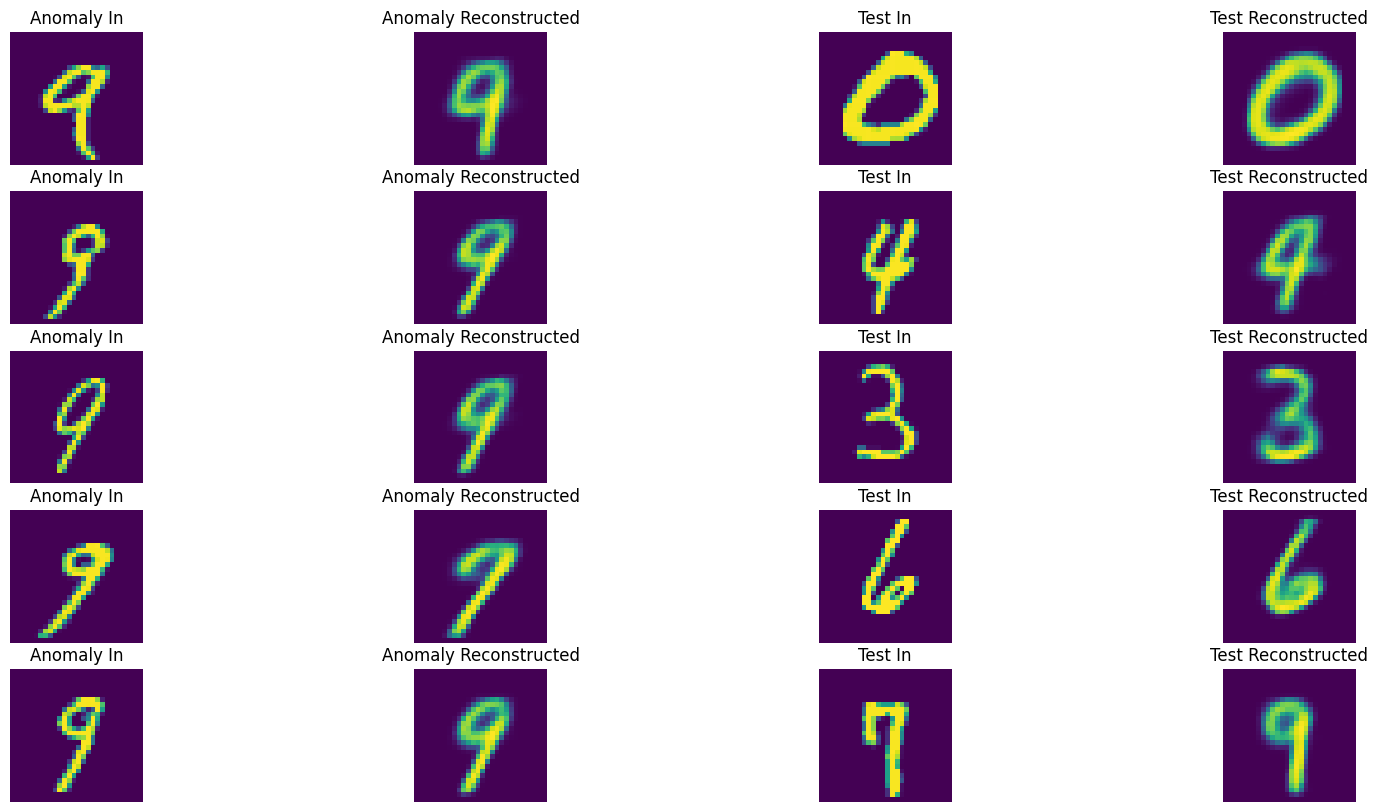

In [423]:
fig, m_axs = plt.subplots(5,4, figsize=(20, 10))
[c_ax.axis('off') for c_ax in m_axs.ravel()]
for i, (axa_in, axa_vae, axt_in, axt_vae) in enumerate(m_axs):
    axa_in.imshow(anomaly_test[i,:,:,0])
    axa_in.set_title('Anomaly In')
    axa_vae.imshow(vae.predict(anomaly_test[i:i+1])[0,:,:,0])
    axa_vae.set_title('Anomaly Reconstructed')
    axt_in.imshow(X_test[i,:,:,0])
    axt_in.set_title('Test In')
    axt_vae.imshow(vae.predict(X_test[i:i+1])[0,:,:,0])
    axt_vae.set_title('Test Reconstructed')